In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns;sns.set()
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat, getcond, oversizedsyms
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym,normcondentropy
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

In [2]:
def loadsyms(states):
    if states == 5:
        print("LOAD LOWER ORDER AND FULL ONLY")
        with open('../../results/sudokus/permutation_sudokus_states'+str(states)+'.npy', 'rb') as f:
            fullsyms = np.load(f,allow_pickle=True)
            syms = list(fullsyms)
        with open('../../results/sudokus/lowerorder_sudokus_states'+str(states)+'.pkl', 'rb') as f:
            lowerorders=pickle.load(f)
            syms = syms+list(lowerorders)
        syms=np.array(syms)
    else:
        with open('../../results/sudokus/constructedSRVstates'+str(states)+'.npy', 'rb') as f:
            syms = np.load(f,allow_pickle=True)
    return syms

def classifylowerorders(syms,k,cs):
    classes = {}
    states = len(syms[0][0])
    syms=syms[cs[k]]
    for i,ix in enumerate(cs[k]):
        s = syms[i]
        order = 0
        for row in s:
            cur = states-len(np.where(row==1/states)[0])
            if cur!=0 and order == 0:
                order = int(cur)
            else:
                continue
        k = 'lower order states '+str(order)
        if k not in classes.keys():
            classes[k] = []
        classes['lower order states '+str(order)].append(ix)
    return classes

In [9]:
states = 5
lenX = 2
subjects=np.arange(lenX)
syms = loadsyms(states)
l,cs=classify_syms(syms,states)
print(cs.keys())

if states == 2:
    kix='lower order sym'
else:
    kix='noisy sym'
lowercs = classifylowerorders(syms,kix,cs)
for k in lowercs:
    cs[k] = lowercs[k]
cs.pop(kix)
if 'lower order states '+str(states) in lowercs.keys():
    cs['noisy sym']=cs.pop('lower order states '+str(states))
print(cs.keys())

if states!=5:
    dist_type = 'comparisonrandom'
    ds = []
    folder = '../../results/syndisc_syms/'
    os.chdir(folder)
    name = dist_type +'states'+str(states)
    allfiles = glob.glob("*.pkl")
    files = [file for file in allfiles if name in file]
    if len(files) != 0:
        print(files)
        ds.append(pd.concat([pd.read_pickle(f) for f in files]))
    os.chdir('../../code/plot_notebooks')
    d = pd.concat(ds)
    d['I(Xi;S)'] = d['I(Xi;S)'].apply(lambda x: sum(x))
    d=d.head(1000)
    print(d.keys()[:25])
else:
    syms=syms[cs['full sym']]

LOAD LOWER ORDER AND FULL ONLY
dict_keys(['full sym', 'noisy sym'])
dict_keys(['full sym', 'lower order states 2', 'lower order states 3', 'lower order states 4'])


## best sym classes given X

In [6]:
def costsymX(row,syms):
    print(row['systemID'],datetime.fromtimestamp(time.time()))
    lenX=row['lenX']
    pX=row['pX']
    subjects=np.arange(lenX)
    costs = []
    mincost = 1000
    minid=-1
    for i,s in enumerate(syms):
        pXSym = appendtoPXS(lenX,pX,pX,s)
        d = dit.Distribution.from_ndarray(pXSym)
        totmi = dit.shannon.mutual_information(d,subjects,[lenX])
        indivmi = sum([dit.shannon.mutual_information(d,[j],[lenX]) for j in subjects])
        wms = totmi-indivmi
        cost = (row['syn_upper'] - wms)/row['syn_upper']
        if totmi!=0:
            cost+=(indivmi/totmi)
        else:
            cost+=indivmi
        costs.append(cost)
        if cost < mincost:
            mincost=cost
            minid=i            
    row['costs']=costs
    row['bestid']=minid
    return row

#compute cost of sym given row
if states==5:
    data = {'systemID':[],'lenX':[],'pX':[],'syn_upper':[]}
    for i in range(1000):
        data['systemID'].append(i)
        data['lenX'].append(2)
        jx = JointProbabilityMatrix(2,states)
        data['pX'].append(jx.joint_probabilities.joint_probabilities)
        data['syn_upper'].append(synergistic_entropy_upper_bound(jx))
    d = pd.DataFrame(data=data)
    
plot = d[['systemID','lenX','pX','syn_upper']]
plot = plot.apply(lambda row: costsymX(row,syms),axis=1)

0 2022-05-05 01:30:47.692692
1 2022-05-05 01:30:59.082967
2 2022-05-05 01:31:12.147912
3 2022-05-05 01:31:25.262539
4 2022-05-05 01:31:38.732545
5 2022-05-05 01:31:51.163094
6 2022-05-05 01:32:03.782763
7 2022-05-05 01:32:15.987760
8 2022-05-05 01:32:28.177307
9 2022-05-05 01:32:40.037543
10 2022-05-05 01:32:51.902784
11 2022-05-05 01:33:03.832615
12 2022-05-05 01:33:15.526621
13 2022-05-05 01:33:27.172549
14 2022-05-05 01:33:38.912555
15 2022-05-05 01:33:50.837179
16 2022-05-05 01:34:02.792122
17 2022-05-05 01:34:14.882441
18 2022-05-05 01:34:27.002509
19 2022-05-05 01:34:39.087402
20 2022-05-05 01:34:51.172329
21 2022-05-05 01:35:03.472112
22 2022-05-05 01:35:15.572628
23 2022-05-05 01:35:27.812057
24 2022-05-05 01:35:39.872235
25 2022-05-05 01:35:52.036882
26 2022-05-05 01:36:04.212279
27 2022-05-05 01:36:16.972324
28 2022-05-05 01:36:29.295139
29 2022-05-05 01:36:41.402077
30 2022-05-05 01:36:52.792198
31 2022-05-05 01:37:04.062312
32 2022-05-05 01:37:15.466939
33 2022-05-05 01:37:

268 2022-05-05 02:22:27.500015
269 2022-05-05 02:22:38.231886
270 2022-05-05 02:22:49.240457
271 2022-05-05 02:22:59.626639
272 2022-05-05 02:23:10.744424
273 2022-05-05 02:23:21.543767
274 2022-05-05 02:23:32.508058
275 2022-05-05 02:23:43.210773
276 2022-05-05 02:23:53.840394
277 2022-05-05 02:24:04.380440
278 2022-05-05 02:24:15.254716
279 2022-05-05 02:24:26.278339
280 2022-05-05 02:24:37.046970
281 2022-05-05 02:24:47.956961
282 2022-05-05 02:24:59.073578
283 2022-05-05 02:25:09.610254
284 2022-05-05 02:25:20.552651
285 2022-05-05 02:25:31.274450
286 2022-05-05 02:25:42.138727
287 2022-05-05 02:25:53.422999
288 2022-05-05 02:26:05.013238
289 2022-05-05 02:26:16.294788
290 2022-05-05 02:26:27.813773
291 2022-05-05 02:26:38.502785
292 2022-05-05 02:26:48.537191
293 2022-05-05 02:26:58.895265
294 2022-05-05 02:27:09.266896
295 2022-05-05 02:27:19.293672
296 2022-05-05 02:27:29.275988
297 2022-05-05 02:27:39.230334
298 2022-05-05 02:27:49.235189
299 2022-05-05 02:27:59.208155
300 2022

533 2022-05-05 03:10:14.721022
534 2022-05-05 03:10:26.037992
535 2022-05-05 03:10:37.255557
536 2022-05-05 03:10:48.168941
537 2022-05-05 03:10:59.082586
538 2022-05-05 03:11:10.354656
539 2022-05-05 03:11:21.308183
540 2022-05-05 03:11:32.097131
541 2022-05-05 03:11:43.066443
542 2022-05-05 03:11:53.607759
543 2022-05-05 03:12:04.410161
544 2022-05-05 03:12:15.203052
545 2022-05-05 03:12:26.442149
546 2022-05-05 03:12:37.315935
547 2022-05-05 03:12:48.556443
548 2022-05-05 03:12:59.407841
549 2022-05-05 03:13:10.322502
550 2022-05-05 03:13:21.460402
551 2022-05-05 03:13:32.290565
552 2022-05-05 03:13:42.918082
553 2022-05-05 03:13:53.693193
554 2022-05-05 03:14:04.694917
555 2022-05-05 03:14:15.606872
556 2022-05-05 03:14:26.502651
557 2022-05-05 03:14:37.229931
558 2022-05-05 03:14:48.312162
559 2022-05-05 03:14:59.291517
560 2022-05-05 03:15:09.939469
561 2022-05-05 03:15:20.975121
562 2022-05-05 03:15:31.951161
563 2022-05-05 03:15:42.380777
564 2022-05-05 03:15:53.228116
565 2022

798 2022-05-05 03:57:04.873161
799 2022-05-05 03:57:15.488827
800 2022-05-05 03:57:26.925388
801 2022-05-05 03:57:37.682651
802 2022-05-05 03:57:48.368920
803 2022-05-05 03:57:59.237302
804 2022-05-05 03:58:09.160353
805 2022-05-05 03:58:22.086123
806 2022-05-05 03:58:33.781157
807 2022-05-05 03:58:43.580553
808 2022-05-05 03:58:53.326956
809 2022-05-05 03:59:03.196718
810 2022-05-05 03:59:13.198611
811 2022-05-05 03:59:23.279303
812 2022-05-05 03:59:35.149125
813 2022-05-05 03:59:49.756142
814 2022-05-05 04:00:03.989713
815 2022-05-05 04:00:16.569076
816 2022-05-05 04:00:26.814647
817 2022-05-05 04:00:36.680631
818 2022-05-05 04:00:46.794825
819 2022-05-05 04:00:56.644005
820 2022-05-05 04:01:07.013797
821 2022-05-05 04:01:17.526303
822 2022-05-05 04:01:28.189942
823 2022-05-05 04:01:38.858505
824 2022-05-05 04:01:49.269205
825 2022-05-05 04:01:59.770598
826 2022-05-05 04:02:10.464029
827 2022-05-05 04:02:21.217449
828 2022-05-05 04:02:32.031276
829 2022-05-05 04:02:42.721607
830 2022

In [7]:
# scatterplot indvmi and totmi of best constructed SRV
lenX=2
subjects=np.arange(lenX)
def costsym(row,syms):
    best = syms[row['bestid']]
    pXSym = appendtoPXS(lenX,row['pX'],row['pX'],best)
    d = dit.Distribution.from_ndarray(pXSym)
    row['I(X;bestsym)'] = dit.shannon.mutual_information(d,subjects,[lenX])
    row['I(Xi;bestsym)'] = sum([dit.shannon.mutual_information(d,[j],[lenX]) for j in subjects])
    return row
plot=plot.apply(lambda row:costsym(row,syms),axis=1)

<AxesSubplot:xlabel='I(Xi;bestsym)', ylabel='I(X;bestsym)'>

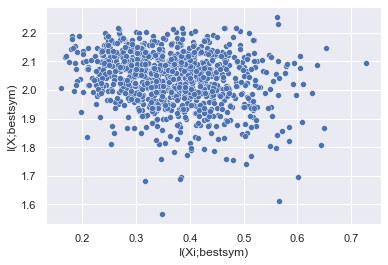

In [8]:
plot.to_pickle("../../results/test/datafig22states"+str(states)+".pkl") 
sns.scatterplot(data=plot,x='I(Xi;bestsym)',y='I(X;bestsym)')

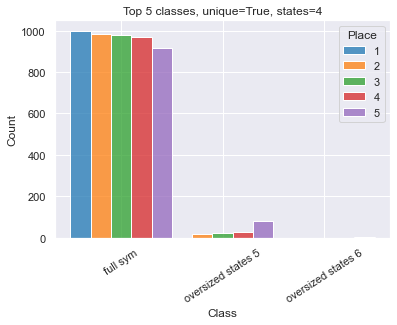

In [25]:
# hist of top5 classes 
histdata = {n:[] for n in np.arange(5)+1}
unique5=True
costs = plot['costs'].values
for cost in costs:
    arrconds = []
    for i,c in enumerate(cost):
        kx = [k for k,v in cs.items() if i in v][0]
        arrconds.append([kx,c])
    arr = np.array(arrconds)
    arr = arr[arr[:, 1].argsort()]
    
    if unique5:
        # only keep top 5 unique values
        top5 = arr[np.unique(arr[:,1], return_index=True)[1]][:5]
    else:
        top5=arr[:5]
    for i,c in enumerate(top5[:,0]):
        histdata[i+1].append(c)
        
histd = pd.DataFrame(data=histdata)
histd = histd.melt(value_vars=list(histdata.keys()),
              var_name='Place', value_name='Class')

g=sns.histplot(data=histd,x='Class',hue='Place',multiple='dodge',palette='tab10')
plt.xticks(rotation=33)
plt.title("Top 5 classes, unique="+str(unique5)+', states='+str(states))
plt.show()

## best sym classes given Sfound

In [ ]:
keepkeys = ['exp_sort', 'systemID', 'syn_upper', 'pX',
       'I(X1;X2)', 'tot_runtime', 'syn_info', 'lenX',
       'states',
       'H(X0)', 'H(X1)', 'H(S)', 'I(X;S)', 'I(Xi;S)', 'pXS', 'WMS(X;S)']
df=d[keepkeys]
df = df.apply(lambda row:normcondentropy(row,syms),axis=1)
df

0 2022-05-04 23:23:22.428499
1 2022-05-04 23:23:23.763009
2 2022-05-04 23:23:25.087864
3 2022-05-04 23:23:26.406255
4 2022-05-04 23:23:27.765863
5 2022-05-04 23:23:29.144587
6 2022-05-04 23:23:30.443360
7 2022-05-04 23:23:31.734536
8 2022-05-04 23:23:33.075190
9 2022-05-04 23:23:34.386128
10 2022-05-04 23:23:35.717472
11 2022-05-04 23:23:38.412322
12 2022-05-04 23:23:40.071255
13 2022-05-04 23:23:41.435423
14 2022-05-04 23:23:42.775792
15 2022-05-04 23:23:44.274396
16 2022-05-04 23:23:45.693411
17 2022-05-04 23:23:47.166562
18 2022-05-04 23:23:48.524038
19 2022-05-04 23:23:49.889982
20 2022-05-04 23:23:51.373034
21 2022-05-04 23:23:52.692150
22 2022-05-04 23:23:54.006372
23 2022-05-04 23:23:55.317073
24 2022-05-04 23:23:56.617320
25 2022-05-04 23:23:57.919362
26 2022-05-04 23:23:59.264135
27 2022-05-04 23:24:00.592392
28 2022-05-04 23:24:02.020891
29 2022-05-04 23:24:03.405661
30 2022-05-04 23:24:04.894139


In [ ]:
allconds = df['H(Sfound|Sym)'].values
histdata = {n:[] for n in np.arange(5)+1}
unique5=False
for conds in allconds:
    arrconds = []
    for i,c in enumerate(conds):
        kx = [k for k,v in cs.items() if i in v][0]
        arrconds.append([kx,c])
    arr = np.array(arrconds)
    arr = arr[arr[:, 1].argsort()]
    
    if unique5:
        # only keep top 5 unique values
        top5 = arr[np.unique(arr[:,1], return_index=True)[1]][:5]
    else:
        top5=arr[:5]
    for i,c in enumerate(top5[:,0]):
        histdata[i+1].append(c)
        
histd = pd.DataFrame(data=histdata)
histd = histd.melt(value_vars=list(histdata.keys()),
              var_name='Place', value_name='Class')

In [ ]:
g=sns.histplot(data=histd,x='Class',hue='Place',multiple='dodge',palette='tab10')
plt.xticks(rotation=45)
plt.title("Top 5 classes, unique="+str(unique5)+', states='+str(states))
plt.show()

## load and plot all datafig22 data

In [67]:
states = [2,3,4,5]
lenX = 2
subjects=np.arange(lenX)

dist_type = 'datafig22states'
ds = []
folder = '../../results/rq22/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
if len(allfiles) != 0:
    for s in states:
        name = dist_type+str(s)
        files = [file for file in allfiles if name in file]
        ds.append(pd.concat([pd.read_pickle(f) for f in files]))
        ds[-1]['states']=s
    os.chdir('../../code/plot_notebooks')
d = pd.concat(ds)
d.keys()

Index(['systemID', 'lenX', 'pX', 'syn_upper', 'syn_info', 'I(X;S)', 'I(Xi;S)',
       'costs', 'bestid', 'I(X;bestsym)', 'I(Xi;bestsym)', 'states'],
      dtype='object')

<AxesSubplot:xlabel='normindivmi', ylabel='syn_info'>

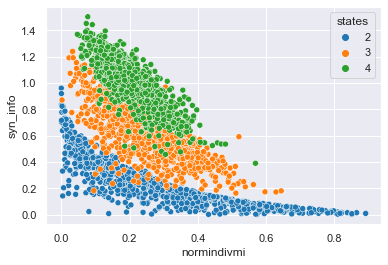

In [70]:
d=d[d['states']!=5]
d['normsyn']=d['syn_info']/d['syn_upper']
d['normindivmi']=d['I(Xi;bestsym)']/d['I(X;bestsym)']
sns.scatterplot(data=d,x='normindivmi',y='syn_info',palette='tab10',hue='states')
# sns.scatterplot(data=d,x='syn_upper',y='syn_info',palette='tab10',hue='states')